<a href="https://colab.research.google.com/github/AyeshaaEman/Federated-Learning-Solar-forecast/blob/main/DL%2CFL_and_ML_on_Solar_Power_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 1: Load datasets & align timestamps

---



In [1]:
import pandas as pd
import numpy as np
import os

# === Function to load dataset with timestamp detection ===
def load_table(path):
    # Always Excel in your case
    df = pd.read_excel(path)

    # Try to find timestamp column
    candidates = ["updated time","timestamp","time","date","datetime",
                  "date_time","DateTime","TIME","Updated Time","TIMESTAMP"]
    found = None
    cols = list(df.columns)

    for c in cols:
        if str(c).strip().lower() in candidates:
            found = c
            break

    if found is None:
        for c in cols:
            try:
                parsed = pd.to_datetime(df[c], errors="coerce")
                if parsed.notna().sum() > 0.4 * len(df):
                    found = c
                    break
            except Exception:
                pass

    if found is None:
        raise ValueError(f"No timestamp column detected in {path}. "
                         f"Please rename your time column to 'timestamp'.")

    # Convert to datetime and set index
    df[found] = pd.to_datetime(df[found], errors="coerce")
    df = df.dropna(subset=[found]).copy()
    df = df.set_index(found).sort_index()
    return df

# === Direct access uploaded files ===
file_paths = ["Data1.xlsx", "Data2.xlsx", "Data3.xlsx"]

clients = {}
for i, p in enumerate(file_paths, start=1):
    if not os.path.exists(p):
        raise FileNotFoundError(f"❌ File not found: {p}. Run !ls to check file names.")
    df = load_table(p)
    clients[f"Client_{i}"] = df

    print("\n" + "="*80)
    print(f"✅ Client_{i} loaded from: {p}")
    print("Rows,Cols:", df.shape)
    print("Columns:", df.columns.tolist())
    print("First 5 rows:")
    print(df.head(5))
    print("="*80)

# === Check timestamp overlap ===
common_idx = None
for name, df in clients.items():
    if common_idx is None:
        common_idx = df.index
    else:
        common_idx = common_idx.intersection(df.index)

print(f"\n📌 Common timestamps across all clients: {len(common_idx)}")



/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")



✅ Client_1 loaded from: Data1.xlsx
Rows,Cols: (7133, 11)
Columns: ['Plant Name', 'Time Zone', 'Production Power(W)', 'Consumption Power(W)', 'Grid Power(W)', 'Purchasing Power(W)', 'Feed-in Power(W)', 'Battery Power(W)', 'Charging Power(W)', 'Discharging Power(W)', 'SoC(%)']
First 5 rows:
                         Plant Name  Time Zone  Production Power(W)  \
Updated Time                                                          
2025-02-01 00:00:00  Hanzala house   UTC+05:00                  0.0   
2025-02-01 00:05:00  Hanzala house   UTC+05:00                  0.0   
2025-02-01 00:10:00  Hanzala house   UTC+05:00                  0.0   
2025-02-01 00:15:00  Hanzala house   UTC+05:00                  0.0   
2025-02-01 00:20:00  Hanzala house   UTC+05:00                  0.0   

                     Consumption Power(W)  Grid Power(W)  Purchasing Power(W)  \
Updated Time                                                                    
2025-02-01 00:00:00                 258.0        

/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")



✅ Client_2 loaded from: Data2.xlsx
Rows,Cols: (7201, 11)
Columns: ['Plant Name', 'Time Zone', 'Production Power(W)', 'Consumption Power(W)', 'Grid Power(W)', 'Purchasing Power(W)', 'Feed-in Power(W)', 'Battery Power(W)', 'Charging Power(W)', 'Discharging Power(W)', 'SoC(%)']
First 5 rows:
                             Plant Name  Time Zone  Production Power(W)  \
Updated Time                                                              
2025-02-01 00:00:00  Inverex Backup 6kW  UTC+05:00                  0.0   
2025-02-01 00:05:00  Inverex Backup 6kW  UTC+05:00                  0.0   
2025-02-01 00:10:00  Inverex Backup 6kW  UTC+05:00                  0.0   
2025-02-01 00:15:00  Inverex Backup 6kW  UTC+05:00                  0.0   
2025-02-01 00:20:00  Inverex Backup 6kW  UTC+05:00                  0.0   

                     Consumption Power(W)  Grid Power(W)  Purchasing Power(W)  \
Updated Time                                                                    
2025-02-01 00:00:00  

/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")



✅ Client_3 loaded from: Data3.xlsx
Rows,Cols: (7259, 11)
Columns: ['Plant Name', 'Time Zone', 'Production Power(W)', 'Consumption Power(W)', 'Grid Power(W)', 'Purchasing Power(W)', 'Feed-in Power(W)', 'Battery Power(W)', 'Charging Power(W)', 'Discharging Power(W)', 'SoC(%)']
First 5 rows:
                              Plant Name  Time Zone  Production Power(W)  \
Updated Time                                                               
2025-02-01 00:00:00  Inverex Smart Load   UTC+05:00                  0.0   
2025-02-01 00:05:00  Inverex Smart Load   UTC+05:00                  0.0   
2025-02-01 00:10:00  Inverex Smart Load   UTC+05:00                  0.0   
2025-02-01 00:15:00  Inverex Smart Load   UTC+05:00                  0.0   
2025-02-01 00:20:00  Inverex Smart Load   UTC+05:00                  0.0   

                     Consumption Power(W)  Grid Power(W)  Purchasing Power(W)  \
Updated Time                                                                    
2025-02-01 00:

# Synchronize clients & keep numeric columns

In [2]:

import pandas as pd

# --- Find common timestamps ---
common_idx = clients["Client_1"].index
for name, df in clients.items():
    common_idx = common_idx.intersection(df.index)

print(f"✅ Common timestamps across all clients: {len(common_idx)}")

# --- Align all clients to common timeline ---
aligned_clients = {}
for name, df in clients.items():
    df_sync = df.loc[common_idx].copy()

    # Keep only numeric columns (for ML/DL training)
    num_cols = df_sync.select_dtypes(include=["number"]).columns.tolist()
    if "Production Power(W)" not in num_cols:
        raise ValueError(f"'Production Power(W)' not found in {name}. Columns are: {df_sync.columns.tolist()}")

    df_sync = df_sync[num_cols]

    # Handle missing values (forward fill → backward fill as backup)
    df_sync = df_sync.fillna(method="ffill").fillna(method="bfill")

    aligned_clients[name] = df_sync

    print("\n" + "="*60)
    print(f"📌 {name} synchronized")
    print("Shape:", df_sync.shape)
    print("Columns:", df_sync.columns.tolist())
    print("Sample rows:")
    print(df_sync.head(3))

# === Check target variable consistency ===
for name, df in aligned_clients.items():
    print(f"{name} target mean: {df['Production Power(W)'].mean():.2f}, std: {df['Production Power(W)'].std():.2f}")

✅ Common timestamps across all clients: 5819

📌 Client_1 synchronized
Shape: (5819, 9)
Columns: ['Production Power(W)', 'Consumption Power(W)', 'Grid Power(W)', 'Purchasing Power(W)', 'Feed-in Power(W)', 'Battery Power(W)', 'Charging Power(W)', 'Discharging Power(W)', 'SoC(%)']
Sample rows:
                     Production Power(W)  Consumption Power(W)  Grid Power(W)  \
Updated Time                                                                    
2025-02-01 00:00:00                  0.0                 258.0           19.0   
2025-02-01 00:05:00                  0.0                 206.0           20.0   
2025-02-01 00:10:00                  0.0                 314.0           17.0   

                     Purchasing Power(W)  Feed-in Power(W)  Battery Power(W)  \
Updated Time                                                                   
2025-02-01 00:00:00                  0.0               0.0             341.0   
2025-02-01 00:05:00                  0.0               0.0    

/tmp/ipython-input-3839130465.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_sync = df_sync.fillna(method="ffill").fillna(method="bfill")
/tmp/ipython-input-3839130465.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_sync = df_sync.fillna(method="ffill").fillna(method="bfill")
/tmp/ipython-input-3839130465.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_sync = df_sync.fillna(method="ffill").fillna(method="bfill")


In [3]:
for name, df in clients.items():
    print(f"{name} columns:", df.columns.tolist())


Client_1 columns: ['Plant Name', 'Time Zone', 'Production Power(W)', 'Consumption Power(W)', 'Grid Power(W)', 'Purchasing Power(W)', 'Feed-in Power(W)', 'Battery Power(W)', 'Charging Power(W)', 'Discharging Power(W)', 'SoC(%)']
Client_2 columns: ['Plant Name', 'Time Zone', 'Production Power(W)', 'Consumption Power(W)', 'Grid Power(W)', 'Purchasing Power(W)', 'Feed-in Power(W)', 'Battery Power(W)', 'Charging Power(W)', 'Discharging Power(W)', 'SoC(%)']
Client_3 columns: ['Plant Name', 'Time Zone', 'Production Power(W)', 'Consumption Power(W)', 'Grid Power(W)', 'Purchasing Power(W)', 'Feed-in Power(W)', 'Battery Power(W)', 'Charging Power(W)', 'Discharging Power(W)', 'SoC(%)']


#  STEP 3: Split into Train/Val/Test (time-series safe)

In [4]:

from sklearn.model_selection import train_test_split

splits = {}  # store split datasets for each client

for name, df in aligned_clients.items():
    X = df.drop(columns=["Production Power(W)"])  # features
    y = df["Production Power(W)"]  # target

    # --- Train/Test split (80% train+val, 20% test) ---
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False  # keep time order
    )

    # --- Train/Validation split (from trainval → 80/20 again) ---
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, test_size=0.2, shuffle=False
    )

    splits[name] = {
        "X_train": X_train, "y_train": y_train,
        "X_val": X_val, "y_val": y_val,
        "X_test": X_test, "y_test": y_test,
    }

    print("\n" + "="*60)
    print(f"📌 {name} dataset split:")
    print("Train:", X_train.shape, "Validation:", X_val.shape, "Test:", X_test.shape)



📌 Client_1 dataset split:
Train: (3724, 8) Validation: (931, 8) Test: (1164, 8)

📌 Client_2 dataset split:
Train: (3724, 8) Validation: (931, 8) Test: (1164, 8)

📌 Client_3 dataset split:
Train: (3724, 8) Validation: (931, 8) Test: (1164, 8)


## STEP 4: Apply Min-Max scaling to features

In [5]:

from sklearn.model_selection import train_test_split

dataset_splits = {}

for name, df in aligned_clients.items():
    X = df.drop(columns=["Production Power(W)"])
    y = df["Production Power(W)"]

    # Train + temp (val+test)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.25, shuffle=False
    )

    # Validation + Test (50/50 of temp = 12.5% each)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, shuffle=False
    )

    dataset_splits[name] = {
        "train": (X_train, y_train),
        "val":   (X_val, y_val),
        "test":  (X_test, y_test)
    }

    print(f"\n📌 {name} dataset split:")
    print("Train:", X_train.shape, "Validation:", X_val.shape, "Test:", X_test.shape)


from sklearn.preprocessing import MinMaxScaler

scalers = {}
scaled_clients = {}

for name, splits in dataset_splits.items():
    X_train, y_train = splits["train"]
    X_val, y_val   = splits["val"]
    X_test, y_test = splits["test"]

    scaler = MinMaxScaler()
    scaler.fit(X_train)   # fit only on training set

    X_train_scaled = scaler.transform(X_train)
    X_val_scaled   = scaler.transform(X_val)
    X_test_scaled  = scaler.transform(X_test)

    scaled_clients[name] = {
        "train": (X_train_scaled, y_train),
        "val":   (X_val_scaled, y_val),
        "test":  (X_test_scaled, y_test)
    }
    scalers[name] = scaler

    print("\n" + "="*60)
    print(f"📌 {name} scaling done")
    print("Original sample (first row before scaling):", X_train.iloc[0].values)
    print("Scaled sample   (first row after scaling): ", X_train_scaled[0])



📌 Client_1 dataset split:
Train: (4364, 8) Validation: (727, 8) Test: (728, 8)

📌 Client_2 dataset split:
Train: (4364, 8) Validation: (727, 8) Test: (728, 8)

📌 Client_3 dataset split:
Train: (4364, 8) Validation: (727, 8) Test: (728, 8)

📌 Client_1 scaling done
Original sample (first row before scaling): [258.  19.   0.   0. 341.   0. 341.  76.]
Scaled sample   (first row after scaling):  [0.1230916  0.11868015 0.         1.         0.60666667 1.
 0.1529834  0.61904762]

📌 Client_2 scaling done
Original sample (first row before scaling): [ 288.  357.  357. -187.  -18.    0.    0.  100.]
Scaled sample   (first row after scaling):  [0.07450382 0.70282881 0.14906054 0.95809993 0.53884809 1.
 0.         1.        ]

📌 Client_3 scaling done
Original sample (first row before scaling): [  29.   97.   97. -142.  -41.    0.    0.  100.]
Scaled sample   (first row after scaling):  [0.01378327 0.60619255 0.03820402 0.96122338 0.42883606 1.
 0.         1.        ]


# STEP 5: Create time-series sequences (24 timesteps × 8 features)

In [6]:
# === Step 5: Create time-series sequences for ML/DL ===
import numpy as np

def create_sequences(X, y, window_size=24):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:(i + window_size)])
        ys.append(y[i + window_size])
    return np.array(Xs), np.array(ys)

window_size = 24  # using past 24 timesteps (~2 hours if 5-min interval)

sequences = {}
for name, splits in scaled_clients.items():
    X_train, y_train = splits["train"]
    X_val, y_val     = splits["val"]
    X_test, y_test   = splits["test"]

    # Build sequences
    X_train_seq, y_train_seq = create_sequences(X_train, y_train, window_size)
    X_val_seq,   y_val_seq   = create_sequences(X_val, y_val, window_size)
    X_test_seq,  y_test_seq  = create_sequences(X_test, y_test, window_size)

    sequences[name] = {
        "train": (X_train_seq, y_train_seq),
        "val":   (X_val_seq,   y_val_seq),
        "test":  (X_test_seq,  y_test_seq)
    }

    print("\n" + "="*60)
    print(f"📌 {name} sequences created")
    print("Train:", X_train_seq.shape, "Val:", X_val_seq.shape, "Test:", X_test_seq.shape)



📌 Client_1 sequences created
Train: (4340, 24, 8) Val: (703, 24, 8) Test: (704, 24, 8)

📌 Client_2 sequences created
Train: (4340, 24, 8) Val: (703, 24, 8) Test: (704, 24, 8)

📌 Client_3 sequences created
Train: (4340, 24, 8) Val: (703, 24, 8) Test: (704, 24, 8)


/tmp/ipython-input-91323442.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ys.append(y[i + window_size])


# STEP 6: Train individual LSTM models per client

In [7]:
# === Step 6: Build and train LSTM models per client ===
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

lstm_models = {}

def build_lstm(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=False, input_shape=input_shape),
        Dropout(0.2),
        Dense(32, activation="relu"),
        Dense(1)  # regression output
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse", metrics=["mae"])
    return model

history_dict = {}

for name, splits in sequences.items():
    X_train, y_train = splits["train"]
    X_val, y_val     = splits["val"]

    # Build model
    model = build_lstm((X_train.shape[1], X_train.shape[2]))
    print(f"\n📌 Training LSTM for {name} ...")

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=32,
        verbose=1
    )

    lstm_models[name] = model
    history_dict[name] = history

    print(f"✅ {name} training finished\n")



📌 Training LSTM for Client_1 ...
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 438443.8438 - mae: 284.7787 - val_loss: 727676.2500 - val_mae: 488.4998
Epoch 2/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 420105.0938 - mae: 317.9333 - val_loss: 658763.1250 - val_mae: 500.0112
Epoch 3/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 365722.5625 - mae: 347.6194 - val_loss: 611827.6250 - val_mae: 517.6459
Epoch 4/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 356582.0312 - mae: 384.4859 - val_loss: 595366.7500 - val_mae: 526.7429
Epoch 5/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 382983.1875 - mae: 414.7501 - val_loss: 591697.3750 - val_mae: 529.0992
Epoch 6/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 379451.7500 - mae: 419.8866 - val_loss: 591176.9375 - val_mae: 529.4379
Epoch 7/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 392989.7812 - mae: 426.1060 - val_loss: 592147.5000 - val_mae: 526.4414
Epoch 8/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 371611.3125 - mae: 

# STEP 7: Evaluate models on test data (MSE, MAE, RMSE, R²)

In [8]:
# === Step 7: Evaluate models on test data ===
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

for name, splits in sequences.items():
    X_test, y_test = splits["test"]
    model = lstm_models[name]

    # Predictions
    y_pred = model.predict(X_test).flatten()

    # Metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print("\n" + "="*60)
    print(f"📌 Evaluation for {name}")
    print(f"MSE : {mse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²  : {r2:.4f}")


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

📌 Evaluation for Client_1
MSE : 60920.2515
MAE : 115.3052
RMSE: 246.8203
R²  : 0.8984
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

📌 Evaluation for Client_2
MSE : 416284.0510
MAE : 327.9042
RMSE: 645.2008
R²  : 0.5993
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

📌 Evaluation for Client_3
MSE : 154756.1952
MAE : 189.3602
RMSE: 393.3906
R²  : 0.7030


# Graphs of Evaluation

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


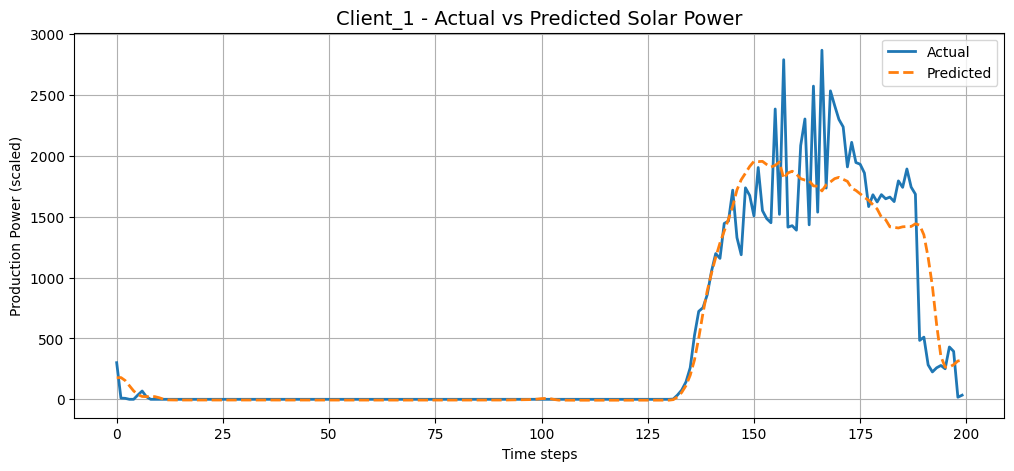

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


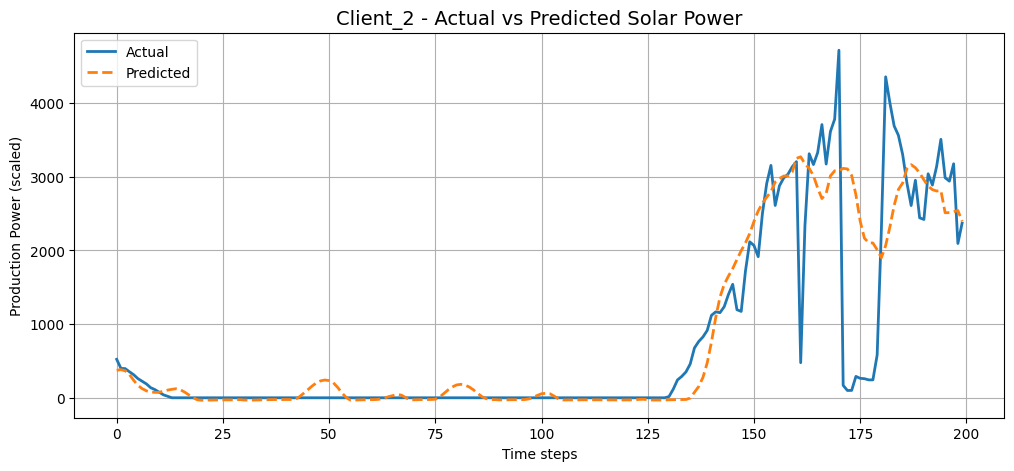

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


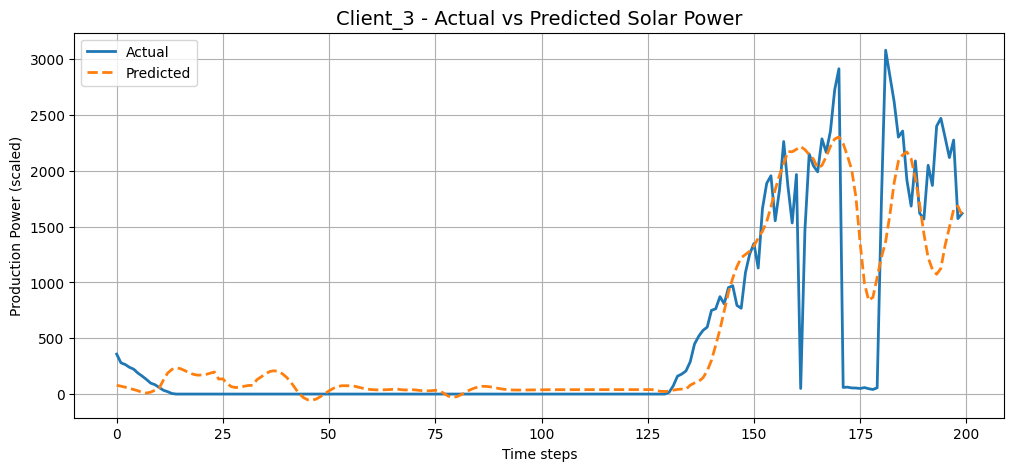

In [9]:

import matplotlib.pyplot as plt

for name, splits in sequences.items():
    X_test, y_test = splits["test"]
    model = lstm_models[name]

    # Predictions
    y_pred = model.predict(X_test).flatten()

    # Plot a sample window (first 200 test points for clarity)
    plt.figure(figsize=(12,5))
    plt.plot(y_test[:200], label="Actual", linewidth=2)
    plt.plot(y_pred[:200], label="Predicted", linestyle="dashed", linewidth=2)
    plt.title(f"{name} - Actual vs Predicted Solar Power", fontsize=14)
    plt.xlabel("Time steps")
    plt.ylabel("Production Power (scaled)")
    plt.legend()
    plt.grid(True)
    plt.show()


# STEP 8: Federated Averaging (aggregate local LSTMs into global model)

In [14]:
from tensorflow.keras.layers import Input

def build_lstm(input_shape):
    model = Sequential([
        Input(shape=input_shape),      # <-- explicit Input layer
        LSTM(64, return_sequences=False),
        Dropout(0.2),
        Dense(32, activation="relu"),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse", metrics=["mae"])
    return model


In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

for name, splits in sequences.items():
    X_test, y_test = splits["test"]

    # Predict using the global FL model
    y_pred = global_model.predict(X_test).flatten()

    # Compute metrics
    mae  = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # manual RMSE
    r2   = r2_score(y_test, y_pred)

    print("\n" + "="*60)
    print(f"📌 Global FL Model Evaluation on {name}")
    print(f"MAE : {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²  : {r2:.4f}")


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

📌 Global FL Model Evaluation on Client_1
MAE : 442.0675
RMSE: 860.8491
R²  : -0.2355
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

📌 Global FL Model Evaluation on Client_2
MAE : 586.0333
RMSE: 1150.5004
R²  : -0.2742
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

📌 Global FL Model Evaluation on Client_3
MAE : 421.3561
RMSE: 808.1501
R²  : -0.2534


# STEP 9: Train ML classifiers (RandomForest, SVM, XGBoost) & compare

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pprint

ml_results = {}

for name, splits in scaled_clients.items():
    X_train, y_train = splits["train"]
    X_val, y_val     = splits["val"]
    X_test, y_test   = splits["test"]

    models_ml = {
        "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
        "SVM": SVR(kernel="rbf"),
        "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.05, random_state=42)
    }

    ml_results[name] = {}
    for model_name, model in models_ml.items():
        # Train ML model
        model.fit(X_train, y_train)

        # Predict on test set
        y_pred = model.predict(X_test)

        # Compute metrics
        mae  = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2   = r2_score(y_test, y_pred)

        ml_results[name][model_name] = {"MAE": mae, "RMSE": rmse, "R²": r2}

# Display results
pprint.pprint(ml_results)


{'Client_1': {'RandomForest': {'MAE': 28.94554945054945,
                               'RMSE': np.float64(111.79819122782438),
                               'R²': 0.9789690846966925},
              'SVM': {'MAE': 368.93698530547147,
                      'RMSE': np.float64(746.2223218179014),
                      'R²': 0.06303128123846069},
              'XGBoost': {'MAE': 34.34588882264523,
                          'RMSE': np.float64(142.11901894537186),
                          'R²': 0.9660145502387885}},
 'Client_2': {'RandomForest': {'MAE': 21.164001831501828,
                               'RMSE': np.float64(49.67153931312219),
                               'R²': 0.9975896594491048},
              'SVM': {'MAE': 516.9103640040129,
                      'RMSE': np.float64(979.8570415861393),
                      'R²': 0.062030740345599966},
              'XGBoost': {'MAE': 31.478933214394193,
                          'RMSE': np.float64(74.09887329583867),
                  

# Visualization  and Comparison

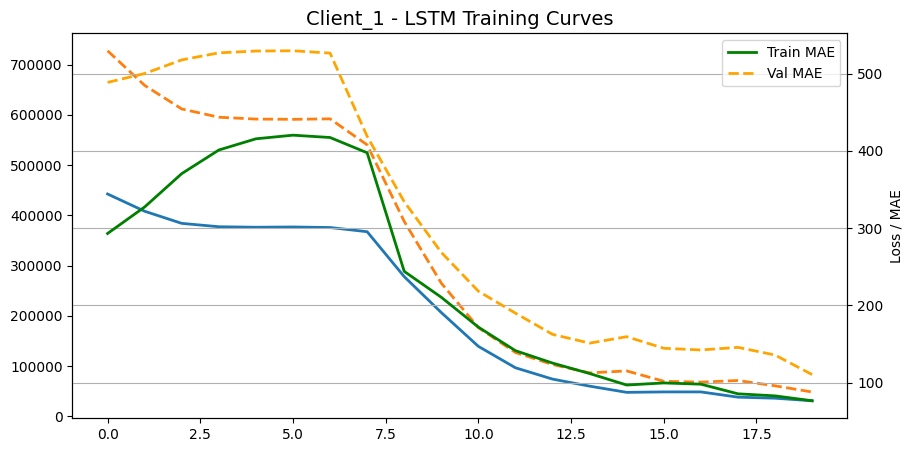

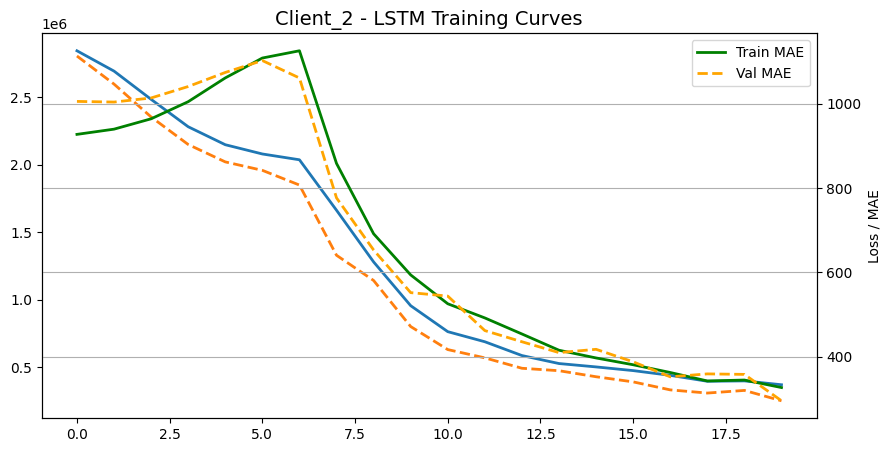

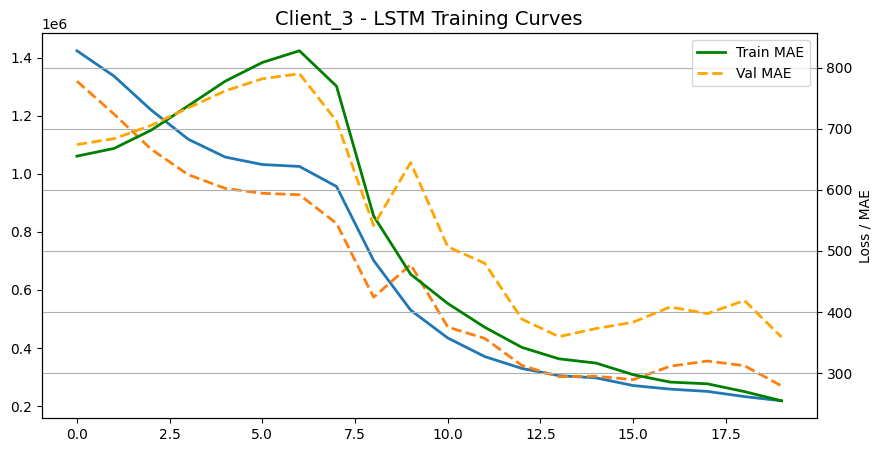

In [17]:
import matplotlib.pyplot as plt

# Plot training and validation loss/MAE for each client
for name, history in history_dict.items():
    plt.figure(figsize=(10,5))

    # Loss curve
    plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2, linestyle='--')

    # MAE curve (secondary y-axis)
    plt.twinx()
    plt.plot(history.history['mae'], label='Train MAE', color='green', linewidth=2)
    plt.plot(history.history['val_mae'], label='Val MAE', color='orange', linewidth=2, linestyle='--')

    plt.title(f"{name} - LSTM Training Curves", fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss / MAE")
    plt.grid(True)

    # Combine legends
    lines, labels = plt.gca().get_legend_handles_labels()
    plt.legend(lines, labels, loc='upper right')

    plt.show()


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


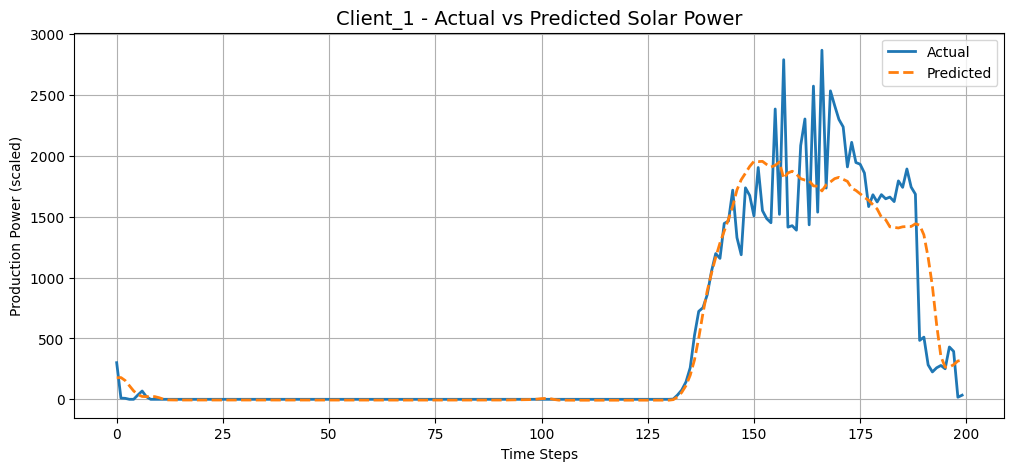

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


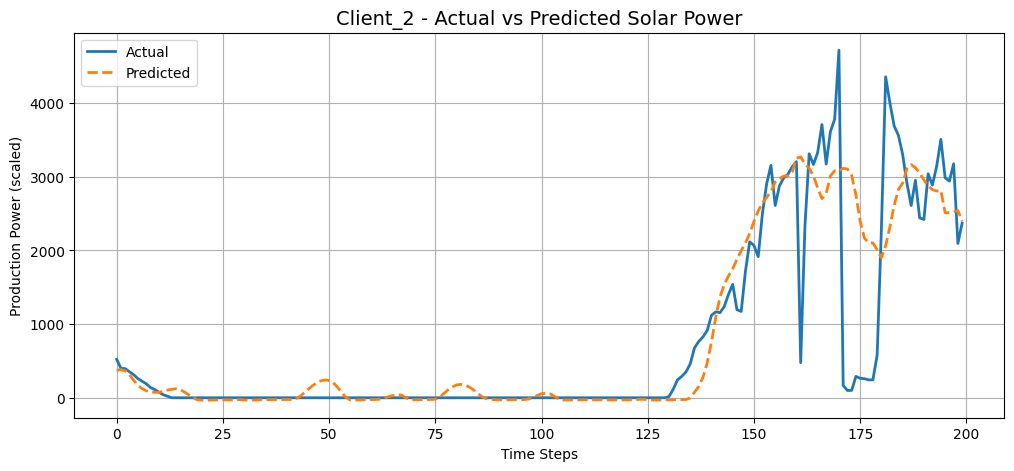

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


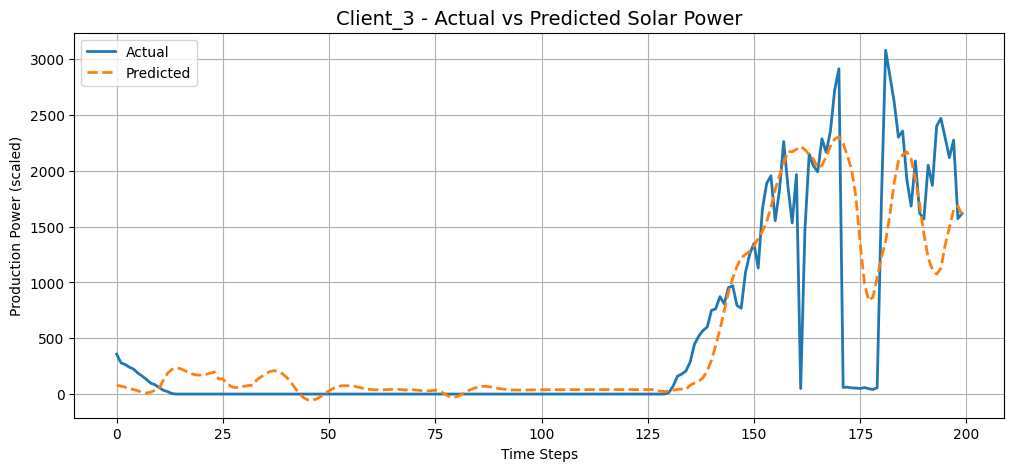

In [18]:
import matplotlib.pyplot as plt

# Plot actual vs predicted for each client
for name, splits in sequences.items():
    X_test, y_test = splits["test"]
    model = lstm_models[name]

    # Predict using LSTM model
    y_pred = model.predict(X_test).flatten()

    plt.figure(figsize=(12,5))
    plt.plot(y_test[:200], label="Actual", linewidth=2)        # first 200 points for clarity
    plt.plot(y_pred[:200], label="Predicted", linestyle="--", linewidth=2)

    plt.title(f"{name} - Actual vs Predicted Solar Power", fontsize=14)
    plt.xlabel("Time Steps")
    plt.ylabel("Production Power (scaled)")
    plt.legend()
    plt.grid(True)
    plt.show()


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


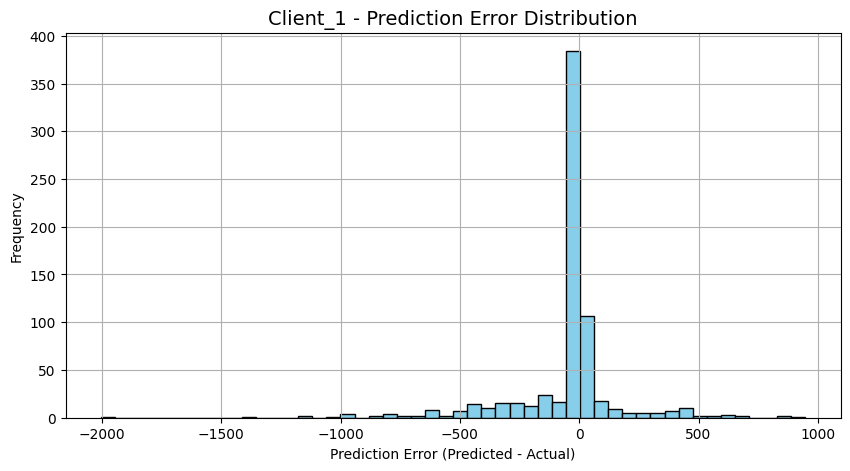

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


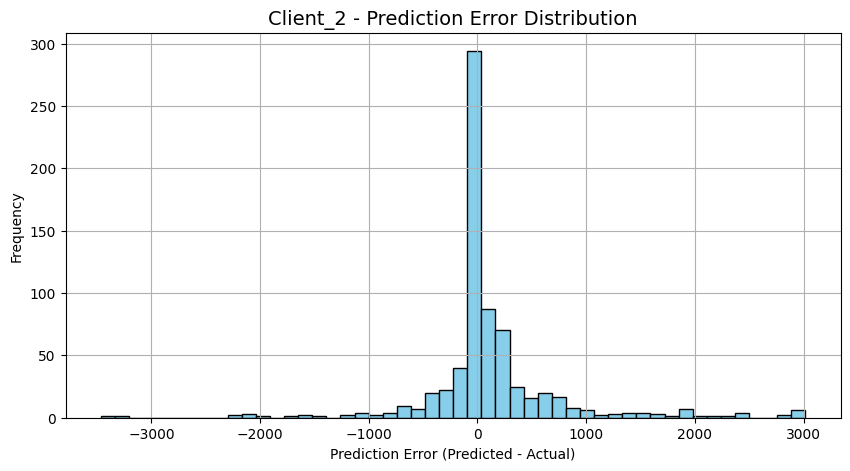

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


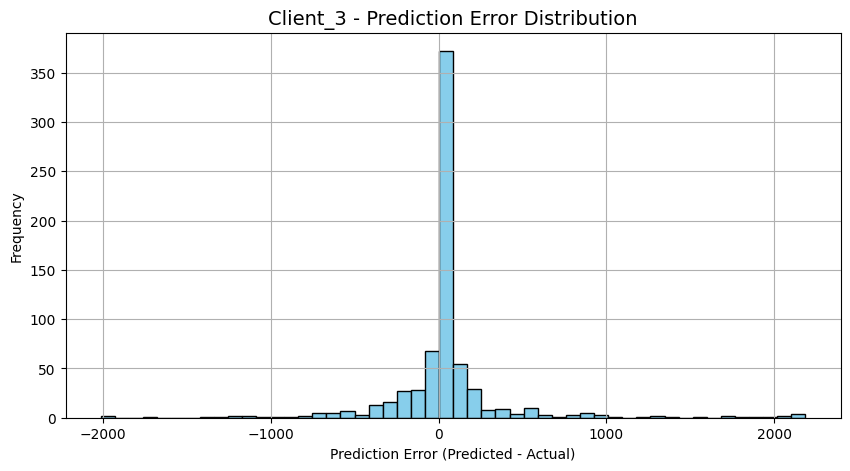

In [20]:
import matplotlib.pyplot as plt

# Plot error distribution for each client
for name, splits in sequences.items():
    X_test, y_test = splits["test"]
    model = lstm_models[name]

    # Predictions
    y_pred = model.predict(X_test).flatten()

    # Compute errors
    errors = y_pred - y_test

    plt.figure(figsize=(10,5))
    plt.hist(errors, bins=50, color='skyblue', edgecolor='black')
    plt.title(f"{name} - Prediction Error Distribution", fontsize=14)
    plt.xlabel("Prediction Error (Predicted - Actual)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()


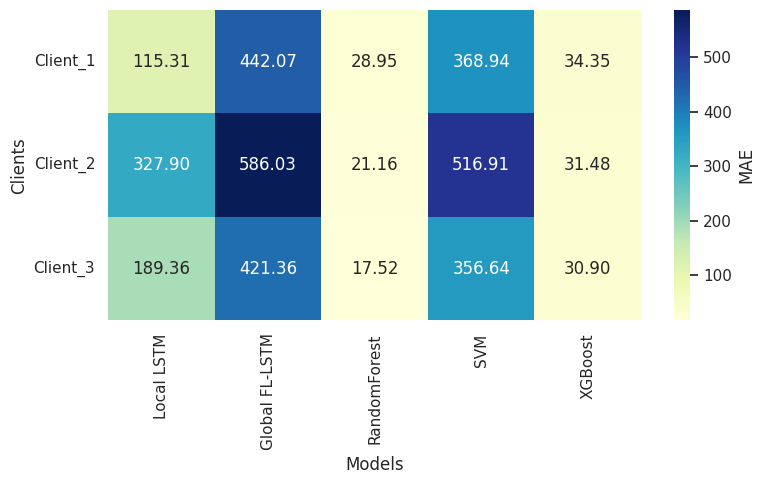

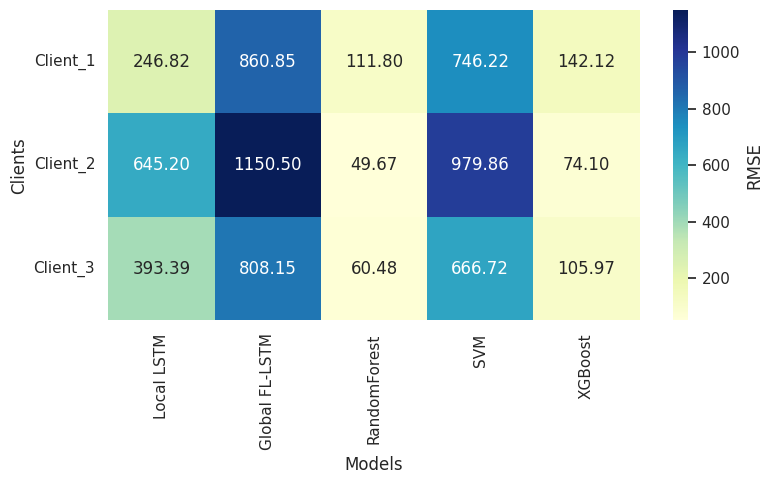

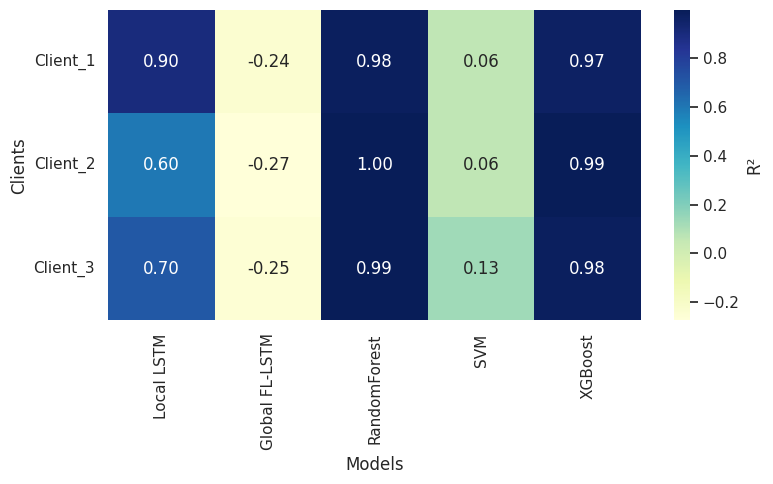

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Clients and models
clients = list(ml_results.keys())
models = ["Local LSTM", "Global FL-LSTM", "RandomForest", "SVM", "XGBoost"]
metrics = ["MAE", "RMSE", "R²"]

# Prepare DataFrames for each metric
heatmaps = {}
for metric in metrics:
    data = []
    for c in clients:
        row = [
            local_metrics[c][metric],
            fl_metrics[c][metric],
            ml_results[c]["RandomForest"][metric],
            ml_results[c]["SVM"][metric],
            ml_results[c]["XGBoost"][metric]
        ]
        data.append(row)
    df = pd.DataFrame(data, index=clients, columns=models)
    heatmaps[metric] = df

# Plot heatmaps
for metric, df in heatmaps.items():
    plt.figure(figsize=(8,5))
    sns.heatmap(df, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': metric})
    plt.ylabel("Clients")
    plt.xlabel("Models")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
